In [20]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Flatten,AveragePooling2D
from tensorflow.keras.applications import MobileNetV2 as MobileNet_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image


In [21]:
dataset_dir = "assets/datasetv2"
train_dir = f"{dataset_dir}/train"
validation_dir = f"{dataset_dir}/valid"
test_dir = f"{dataset_dir}/test"

print(train_dir)

assets/datasetv2/train


In [22]:
def count_images_in_folder(folder_path):
    class_counts = {}
    for label in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, label)
        if os.path.isdir(class_folder):
            num_images = len(os.listdir(class_folder))
            class_counts[label] = num_images
    return class_counts

In [23]:
img_height, img_width = 224, 224
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

def count_images_in_folder(folder_path):
    class_counts = {}
    for label in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, label)
        if os.path.isdir(class_folder):
            num_images = len([
                f for f in os.listdir(class_folder) 
                if os.path.isfile(os.path.join(class_folder, f))
            ])
            class_counts[label] = num_images
    return class_counts

train_class_counts = count_images_in_folder(train_dir)
validation_class_counts = count_images_in_folder(validation_dir)
test_class_counts = count_images_in_folder(test_dir)

print("\nTraining data:", train_class_counts)
print("Validation data:", validation_class_counts)
print("Test data:", test_class_counts)


Found 341 images belonging to 3 classes.
Found 136 images belonging to 3 classes.
Found 105 images belonging to 3 classes.

Training data: {'moderate': 114, 'nomal': 114, 'severe': 113}
Validation data: {'moderate': 43, 'nomal': 49, 'severe': 44}
Test data: {'moderate': 36, 'nomal': 35, 'severe': 34}


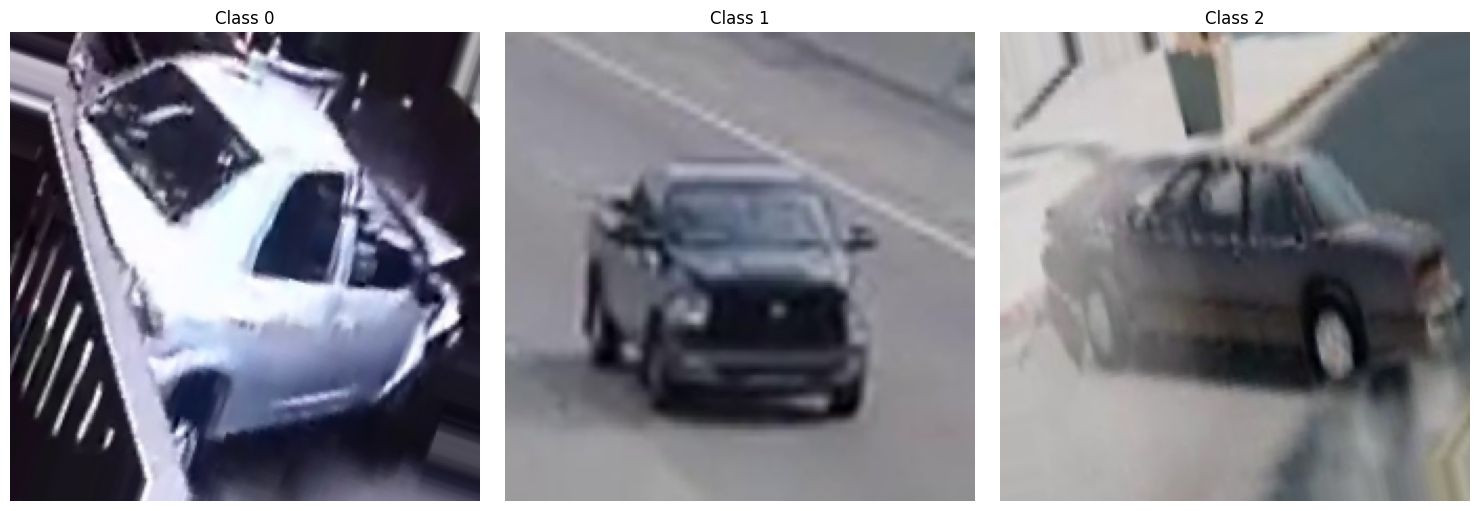

In [24]:
images, labels = next(train_generator)  # Ambil 1 batch data
plt.figure(figsize=(15, 5))

for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i])
        plt.axis("off")
        # Menampilkan label (opsional)
        class_label = np.argmax(labels[i])
        plt.title(f"Class {class_label}")

plt.tight_layout()
plt.show()

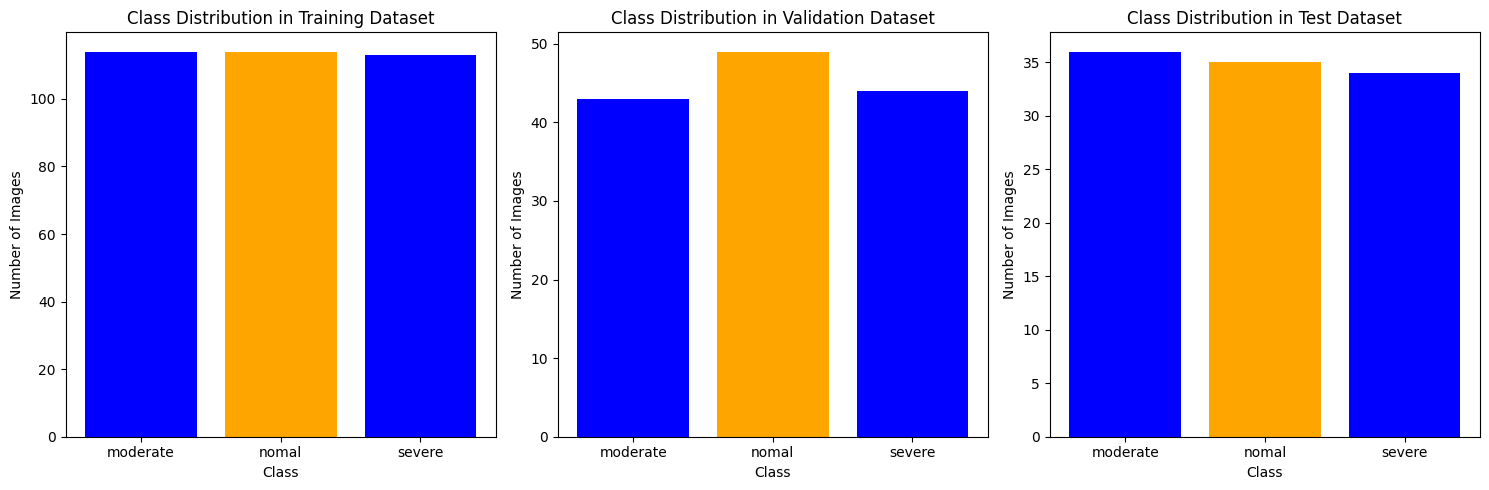

In [25]:
def plot_class_distribution(class_counts, dataset_name, ax):
    labels = list(class_counts.keys())
    counts = list(class_counts.values())

    ax.bar(labels, counts, color=['blue', 'orange'])
    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title(f'Class Distribution in {dataset_name} Dataset')

_, axes = plt.subplots(1, 3, figsize=(15, 5))

plot_class_distribution(train_class_counts, "Training", axes[0])
plot_class_distribution(validation_class_counts, "Validation", axes[1])
plot_class_distribution(test_class_counts, "Test", axes[2])

plt.tight_layout()
plt.show()

In [26]:
# import random

# oversample_datagen = ImageDataGenerator(
#     rotation_range=45,
#     shear_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True
# )

# def oversample_class(input_folder, target_count):
#     current_images = os.listdir(input_folder)
#     num_current = len(current_images)
#     print(f"Oversampling {input_folder}: {num_current} -> {target_count}")

#     for i in range(target_count - num_current):
#         img_name = random.choice(current_images)
#         img_path = os.path.join(input_folder, img_name)

#         img = load_img(img_path)
#         img_array = img_to_array(img)
#         img_array = np.expand_dims(img_array, axis=0)

#         aug_iter = oversample_datagen.flow(img_array, batch_size=1)
#         aug_img = next(aug_iter)[0].astype('uint8')

#         save_img(os.path.join(input_folder, f"aug_{i}.jpg"), aug_img)


# target_samples = 139 
# oversample_class(os.path.join(train_dir, 'moderate'), target_samples)
# oversample_class(os.path.join(train_dir, 'nomal'), target_samples)  
# oversample_class(os.path.join(train_dir, 'severe'), target_samples)  

# print("Training data class:", count_images_in_folder(train_dir))
# print("Validation data class:", count_images_in_folder(validation_dir))
# print("Test data class:", count_images_in_folder(test_dir))

In [27]:
# _, axes = plt.subplots(1, 3, figsize=(15, 5))

# plot_class_distribution(count_images_in_folder(train_dir), "Training", axes[0])
# plot_class_distribution(count_images_in_folder(validation_dir), "Validation", axes[1])
# plot_class_distribution(count_images_in_folder(test_dir), "Test", axes[2])

# plt.tight_layout()
# plt.show()

In [28]:
# model = Sequential([
#     base_model,
#     AveragePooling2D(pool_size=(2, 2)),
#     Flatten(),
#     Dense(1024, kernel_regularizer=l2(0.001), activity_regularizer=l1(0.001), bias_regularizer=l1(0.001), activation='relu'),
#     BatchNormalization(),
#     Dropout(0.1),
#     Dense(3, activation='softmax')
# ])

In [29]:
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

base_model = MobileNet_model(
    input_shape=(img_height, img_width, 3),  
    include_top=False,  
    weights='imagenet'                      
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu',  kernel_regularizer=l2(0.00016), bias_regularizer=l2(0.00016)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu',  kernel_regularizer=l2(0.00016),bias_regularizer=l2(0.00016)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate = 0.000067),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,431,171 (9.27 MB)

 Trainable params: 172,803 (675.01 KB)

 Non-trainable params: 2,258,368 (8.61 MB)

In [30]:
training = model.fit(
    train_generator,
    epochs=25,                             
    validation_data=validation_generator,   
)

Epoch 1/25


c:\Users\Ichwan\.conda\envs\forge-ultralytic\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.3400 - loss: 1.5308 - val_accuracy: 0.3235 - val_loss: 1.3886
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step - accuracy: 0.4201 - loss: 1.4305 - val_accuracy: 0.3603 - val_loss: 1.2631
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 526ms/step - accuracy: 0.4276 - loss: 1.3908 - val_accuracy: 0.3971 - val_loss: 1.1929
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 504ms/step - accuracy: 0.4205 - loss: 1.3918 - val_accuracy: 0.4118 - val_loss: 1.1372
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.4060 - loss: 1.4043 - val_accuracy: 0.4632 - val_loss: 1.0917
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 523ms/step - accuracy: 0.4883 - loss: 1.2243 - val_accuracy: 0.4706 - val_loss: 1.0578
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 507ms/step - accuracy: 0.4505 - loss: 1.3498 - val_accuracy: 0.5000 - val_loss: 1.0300
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.4880 - loss: 1.2464 - val_accuracy: 0.5074 

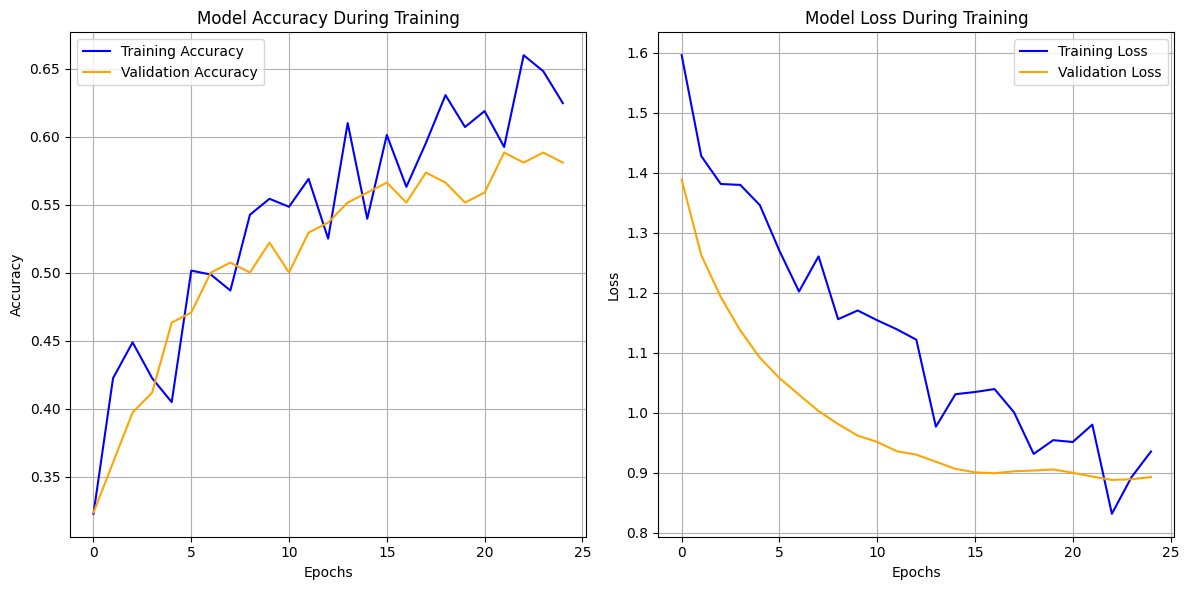

In [31]:
train_accuracy = training.history['accuracy']
val_accuracy = training.history['val_accuracy']
train_loss = training.history['loss']
val_loss = training.history['val_loss']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy During Training')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss During Training')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [32]:
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.4889 - loss: 1.0890
Test Loss: 0.9505883455276489
Test Accuracy: 0.5904762148857117


6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/stepWARNING:tensorflow:6 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E6634E51F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 310ms/step


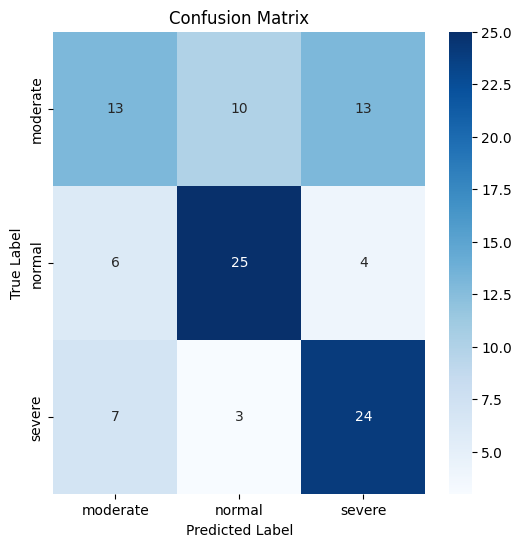

              precision    recall  f1-score   support

    moderate       0.50      0.36      0.42        36
      normal       0.66      0.71      0.68        35
      severe       0.59      0.71      0.64        34

    accuracy                           0.59       105
   macro avg       0.58      0.59      0.58       105
weighted avg       0.58      0.59      0.58       105



In [33]:

y_true = test_generator.classes

y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)  

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['moderate', 'normal', 'severe'],
            yticklabels=['moderate', 'normal', 'severe'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_true, y_pred, target_names=['moderate', 'normal', 'severe']))


### Testing Klasifikasi

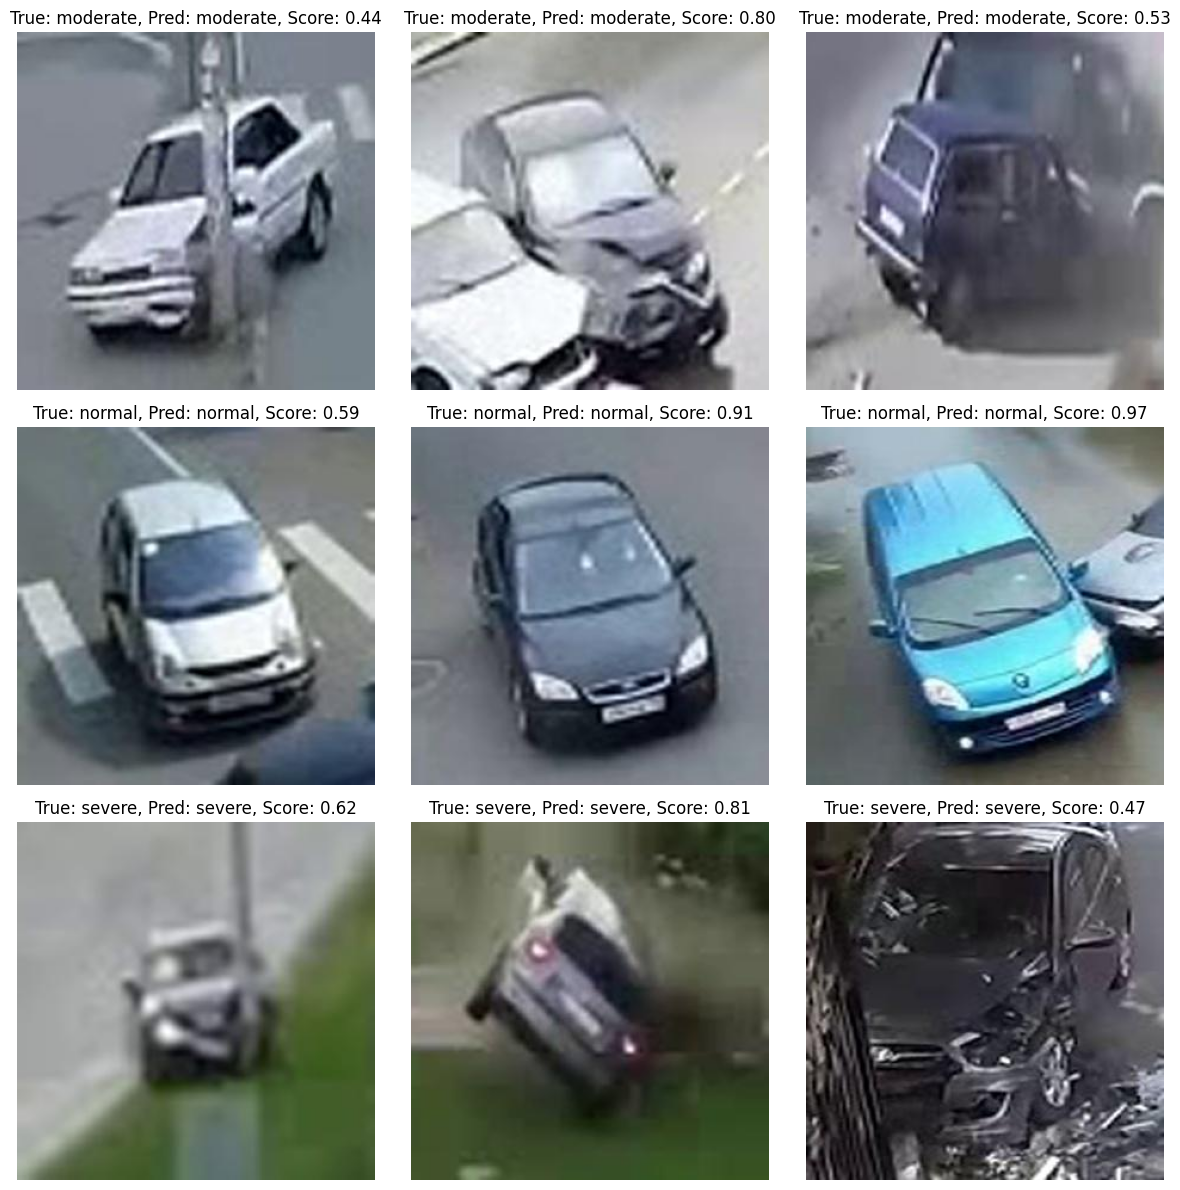

In [34]:
image_paths = test_generator.filepaths
unique_labels = np.unique(y_true)  
images_per_label = 3  

plt.figure(figsize=(12, 4 * len(unique_labels)))  

for label_idx, label in enumerate(unique_labels):
    classified_for_label = np.where((y_true == label) & (y_true == y_pred))[0]
    
    if len(classified_for_label) == 0:
        continue
    
    selected_indices = classified_for_label[:images_per_label]

    for img_idx, idx in enumerate(selected_indices):
        original_img = Image.open(image_paths[idx])

        predicted_class = int(y_pred[idx])
        pred_probability = np.max(y_pred_prob[idx])

        plt.subplot(len(unique_labels), images_per_label, label_idx * images_per_label + img_idx + 1)
        plt.imshow(original_img)
        plt.title(f"True: {['moderate', 'normal', 'severe'][y_true[idx]]}, "
                  f"Pred: {['moderate', 'normal', 'severe'][predicted_class]}, "
                  f"Score: {pred_probability:.2f}")
        plt.axis('off')

plt.tight_layout()
plt.show()


### Miss klasifikasi

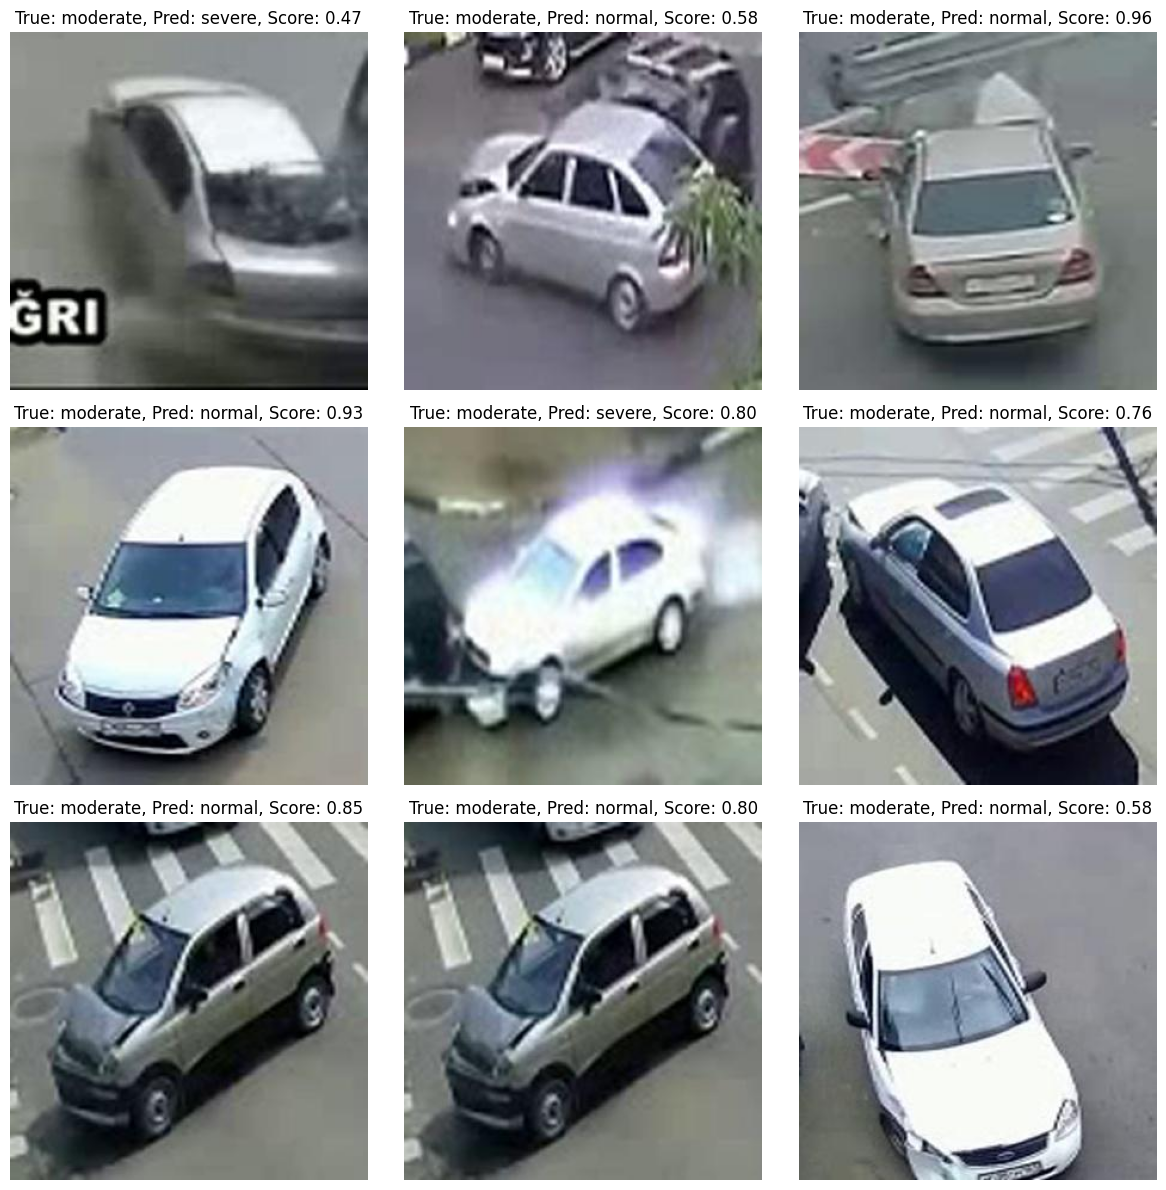

In [35]:
image_paths = test_generator.filepaths

misclassified_indices = np.where(y_true != y_pred)[0]

plt.figure(figsize=(12, 12))  

for i, idx in enumerate(misclassified_indices[:9]): 
    original_img = Image.open(image_paths[idx]) 

    predicted_class = int(y_pred[idx])
    pred_probability = np.max(y_pred_prob[idx])  

    plt.subplot(3, 3, i + 1)
    plt.imshow(original_img)  
    plt.title(f"True: {['moderate', 'normal', 'severe'][y_true[idx]]}, "
              f"Pred: {['moderate', 'normal', 'severe'][predicted_class]}, "
              f"Score: {pred_probability:.2f}")  
    plt.axis('off')

plt.tight_layout()
plt.show()


In [36]:
model.save('MobileNetV2.h5')

In [37]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Muat model
classifier = load_model("MobileNetV2.h5")

# Masukkan gambar uji manual
image_path = "assets/datasetv2/test/nomal/sintetic-49-_jpg.rf.10b1bc62104c7619e2184f8ed1fc9c49.jpg"
image = cv2.imread(image_path)
image_resized = cv2.resize(image, (224, 224))
image_array = np.expand_dims(image_resized, axis=0).astype('float32') / 255.0

# Prediksi
prediction = classifier.predict(image_array)
print(f"Prediksi Model: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Prediksi Model: [[0.14253068 0.7440424  0.11342686]]
